<a href="https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/machine_learning/rnn/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rishi-latchmepersad/TinyML-Home-Weather-Forecasting/blob/main/machine_learning/rnn/model_training.ipynb)

In [193]:
import pandas as pd
from pathlib import Path
import requests
from datetime import datetime


# Import Data
We need to concatenate all readings from the on-device measurement CSVs and augment the dataset with a year of Open-Meteo historical data for Calcutta #3, Couva, Trinidad (August 2024 through August 2025).

In [194]:

# Locate measurement CSVs whether running locally or in Colab
candidate_dirs = [
    Path('/content/measurements'),
    Path('measurements'),
    Path('../measurements'),
]
measurements_dir = None
for candidate in candidate_dirs:
    if candidate.exists():
        measurements_dir = candidate
        break
if measurements_dir is None:
    raise FileNotFoundError("Could not find a measurements directory in the expected locations.")

csv_files = sorted(measurements_dir.glob('measurements_*.csv'))
if not csv_files:
    raise FileNotFoundError(f"No measurement CSVs found under {measurements_dir}")

measurement_dfs = []
for csv_file in csv_files:
    df_temp = pd.read_csv(csv_file)
    measurement_dfs.append(df_temp)

measurement_df = pd.concat(measurement_dfs, ignore_index=True)
print(f"Successfully loaded and concatenated {len(csv_files)} CSV files into a single DataFrame.")
print(f"The final measurement DataFrame has {measurement_df.shape[0]} rows and {measurement_df.shape[1]} columns.")
measurement_df.head()


Successfully loaded and concatenated 48 CSV files into a single DataFrame.
The final measurement DataFrame has 1780778 rows and 5 columns.


,timestamp_iso8601,sensor,quantity,value,unit
0,2025-09-04T22:13:36Z,veml7700,lux_lx,26.342400,lx
1,2025-09-04T22:13:37Z,bme280,temperature_c,29.042791,degC
2,2025-09-04T22:13:37Z,bme280,pressure_pa,100963.773438,Pa
3,2025-09-04T22:13:37Z,bme280,humidity_pct,64.752380,pct
4,2025-09-04T22:13:43Z,lm393,is_raining,0.000000,NaN


In [195]:

# Keep only the columns needed for the long-to-wide pivot and coerce values to numeric
measurement_df = measurement_df[["timestamp_iso8601", "quantity", "value"]]
measurement_df["value"] = pd.to_numeric(measurement_df["value"], errors="coerce")
measurement_df = measurement_df.dropna(subset=["timestamp_iso8601", "quantity", "value"])
measurement_df.head()


,timestamp_iso8601,quantity,value
0,2025-09-04T22:13:36Z,lux_lx,26.342400
1,2025-09-04T22:13:37Z,temperature_c,29.042791
2,2025-09-04T22:13:37Z,pressure_pa,100963.773438
3,2025-09-04T22:13:37Z,humidity_pct,64.752380
4,2025-09-04T22:13:43Z,is_raining,0.000000


## Pull one year of Open-Meteo data for Calcutta #3 (Couva, Trinidad)
We fetch August 2024 through August 2025 hourly history so the model can train on both on-device measurements and public weather data.

In [196]:

openmeteo_params = {
    "latitude": 10.4226,  # Calcutta #3, Couva, Trinidad
    "longitude": -61.4749,
    "start_date": "2024-08-01",
    "end_date": "2025-08-01",
    "hourly": [
        "temperature_2m",
        "relative_humidity_2m",
        "surface_pressure",
        "precipitation",
        "wind_speed_10m",
    ],
    "timezone": "UTC",
}

response = requests.get(
    "https://archive-api.open-meteo.com/v1/archive",
    params={**openmeteo_params, "hourly": ",".join(openmeteo_params["hourly"])},
    timeout=60,
)
response.raise_for_status()
openmeteo_hourly = response.json()["hourly"]

openmeteo_long_records = []
quantity_rename = {
    "temperature_2m": "om_temperature_2m_c",
    "relative_humidity_2m": "om_relative_humidity_pct",
    "surface_pressure": "om_surface_pressure_pa",
    "precipitation": "om_precipitation_mm",
    "wind_speed_10m": "om_wind_speed_10m_ms",
}
for param_key, column_name in quantity_rename.items():
    values = openmeteo_hourly[param_key]
    if param_key == "surface_pressure":
        values = [v * 100 for v in values]
    for ts, value in zip(openmeteo_hourly["time"], values):
        openmeteo_long_records.append(
            {"timestamp_iso8601": ts, "quantity": column_name, "value": value}
        )

openmeteo_df = pd.DataFrame(openmeteo_long_records)
openmeteo_df["timestamp_iso8601"] = pd.to_datetime(
    openmeteo_df["timestamp_iso8601"], utc=True
)
print(
    f"Loaded {len(openmeteo_df)} Open-Meteo rows spanning "
    f"{openmeteo_df['timestamp_iso8601'].min()} to {openmeteo_df['timestamp_iso8601'].max()}."
)
openmeteo_df.head()


Loaded 43920 Open-Meteo rows spanning 2024-08-01 00:00:00+00:00 to 2025-08-01 23:00:00+00:00.


,timestamp_iso8601,quantity,value
0,2024-08-01 00:00:00+00:00,om_temperature_2m_c,25.9
1,2024-08-01 01:00:00+00:00,om_temperature_2m_c,26.3
2,2024-08-01 02:00:00+00:00,om_temperature_2m_c,26.1
3,2024-08-01 03:00:00+00:00,om_temperature_2m_c,26.0
4,2024-08-01 04:00:00+00:00,om_temperature_2m_c,26.0


In [197]:

# Combine the device measurements with the Open-Meteo history
combined_df = pd.concat([measurement_df, openmeteo_df], ignore_index=True)
df = combined_df
df["timestamp_iso8601"] = pd.to_datetime(df["timestamp_iso8601"], format='mixed', utc=True)
print(f"Combined dataset has {len(df)} rows from {df['timestamp_iso8601'].min()} to {df['timestamp_iso8601'].max()}")
df.head()


Combined dataset has 1824698 rows from 2024-08-01 00:00:00+00:00 to 2025-10-21 19:21:30+00:00


,timestamp_iso8601,quantity,value
0,2025-09-04 22:13:36+00:00,lux_lx,26.342400
1,2025-09-04 22:13:37+00:00,temperature_c,29.042791
2,2025-09-04 22:13:37+00:00,pressure_pa,100963.773438
3,2025-09-04 22:13:37+00:00,humidity_pct,64.752380
4,2025-09-04 22:13:43+00:00,is_raining,0.000000


# Data Pre-Processing

## Pivoting - Reformating the data into multiple columns
We make each quantity (measurement type e.g. lux, pressure, temperature) its own column, so each row will have one value per quantity instead of one row per quantity.

In [198]:
df["quantity"].value_counts()

,count
quantity,
lux_lx,358849
is_raining,358586
temperature_c,354560
pressure_pa,354560
humidity_pct,354223
om_temperature_2m_c,8784
om_relative_humidity_pct,8784
om_surface_pressure_pa,8784
om_precipitation_mm,8784


In [199]:
df = df.pivot_table(values='value', index='timestamp_iso8601',
                       columns='quantity', aggfunc="mean").reset_index()
print(df.columns.name)
df.head()

quantity


quantity,timestamp_iso8601,humidity_pct,is_raining,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c
0,2024-08-01 00:00:00+00:00,NaN,NaN,NaN,0.0,88.0,101400.0,25.9,6.6,NaN,NaN
1,2024-08-01 01:00:00+00:00,NaN,NaN,NaN,0.0,87.0,101440.0,26.3,8.0,NaN,NaN
2,2024-08-01 02:00:00+00:00,NaN,NaN,NaN,0.0,87.0,101460.0,26.1,8.7,NaN,NaN
3,2024-08-01 03:00:00+00:00,NaN,NaN,NaN,0.0,86.0,101460.0,26.0,7.2,NaN,NaN
4,2024-08-01 04:00:00+00:00,NaN,NaN,NaN,0.0,86.0,101400.0,26.0,6.3,NaN,NaN


In [200]:
df.columns.name = None

In [201]:

# Drop rain indicator if present (older datasets sometimes include it)
if "is_raining" in df.columns:
    df = df.drop(["is_raining"], axis=1)
df.head()


,timestamp_iso8601,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c
0,2024-08-01 00:00:00+00:00,NaN,NaN,0.0,88.0,101400.0,25.9,6.6,NaN,NaN
1,2024-08-01 01:00:00+00:00,NaN,NaN,0.0,87.0,101440.0,26.3,8.0,NaN,NaN
2,2024-08-01 02:00:00+00:00,NaN,NaN,0.0,87.0,101460.0,26.1,8.7,NaN,NaN
3,2024-08-01 03:00:00+00:00,NaN,NaN,0.0,86.0,101460.0,26.0,7.2,NaN,NaN
4,2024-08-01 04:00:00+00:00,NaN,NaN,0.0,86.0,101400.0,26.0,6.3,NaN,NaN


In [202]:
len(df)

1031782

In [203]:
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c
0,2024-08-01 00:00:00+00:00,NaN,NaN,0.0,88.0,101400.0,25.9,6.6,NaN,NaN
1,2024-08-01 01:00:00+00:00,NaN,NaN,0.0,87.0,101440.0,26.3,8.0,NaN,NaN
2,2024-08-01 02:00:00+00:00,NaN,NaN,0.0,87.0,101460.0,26.1,8.7,NaN,NaN
3,2024-08-01 03:00:00+00:00,NaN,NaN,0.0,86.0,101460.0,26.0,7.2,NaN,NaN
4,2024-08-01 04:00:00+00:00,NaN,NaN,0.0,86.0,101400.0,26.0,6.3,NaN,NaN


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031782 entries, 0 to 1031781
Data columns (total 10 columns):
 #   Column                    Non-Null Count    Dtype              
---  ------                    --------------    -----              
 0   timestamp_iso8601         1031782 non-null  datetime64[ns, UTC]
 1   humidity_pct              354108 non-null   float64            
 2   lux_lx                    358755 non-null   float64            
 3   om_precipitation_mm       8784 non-null     float64            
 4   om_relative_humidity_pct  8784 non-null     float64            
 5   om_surface_pressure_pa    8784 non-null     float64            
 6   om_temperature_2m_c       8784 non-null     float64            
 7   om_wind_speed_10m_ms      8784 non-null     float64            
 8   pressure_pa               354446 non-null   float64            
 9   temperature_c             354466 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(9)
memory usage: 78

## Resampling - Handling small gaps between sensor readings
Each quantity is captured by a different sensor. Since the data is captured every 10 seconds, there may be very slight differences (seconds or milliseconds) between when each sensor actually captures its information. This results in readings that represent the same 10 second period appear as different rows. In reality, they should represent the same instance. **Resampling** organizes the data into 30 minute chunks, and takes the average of each value within that 30 minute chunk, thus consolidating them into a single row.

In [205]:
df["timestamp_iso8601"] = pd.to_datetime(df["timestamp_iso8601"], format='mixed')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031782 entries, 0 to 1031781
Data columns (total 10 columns):
 #   Column                    Non-Null Count    Dtype              
---  ------                    --------------    -----              
 0   timestamp_iso8601         1031782 non-null  datetime64[ns, UTC]
 1   humidity_pct              354108 non-null   float64            
 2   lux_lx                    358755 non-null   float64            
 3   om_precipitation_mm       8784 non-null     float64            
 4   om_relative_humidity_pct  8784 non-null     float64            
 5   om_surface_pressure_pa    8784 non-null     float64            
 6   om_temperature_2m_c       8784 non-null     float64            
 7   om_wind_speed_10m_ms      8784 non-null     float64            
 8   pressure_pa               354446 non-null   float64            
 9   temperature_c             354466 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(9)
memory usage: 78

In [206]:
# In the original dataset, the sensor readings may have come in at very slightly
# different times, i.e. 1 second apart. But each of these should have technically
# been one instance. So we resample, to get the average of each value within the
# specified resample time.

df = df.set_index("timestamp_iso8601").resample('30min').mean()
df.head()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c
timestamp_iso8601,,,,,,,,,
2024-08-01 00:00:00+00:00,NaN,NaN,0.0,88.0,101400.0,25.9,6.6,NaN,NaN
2024-08-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-01 01:00:00+00:00,NaN,NaN,0.0,87.0,101440.0,26.3,8.0,NaN,NaN
2024-08-01 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-01 02:00:00+00:00,NaN,NaN,0.0,87.0,101460.0,26.1,8.7,NaN,NaN


In [207]:
len(df)

21447

In [208]:
df = df.sort_values("timestamp_iso8601")
df.head()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c
timestamp_iso8601,,,,,,,,,
2024-08-01 00:00:00+00:00,NaN,NaN,0.0,88.0,101400.0,25.9,6.6,NaN,NaN
2024-08-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-01 01:00:00+00:00,NaN,NaN,0.0,87.0,101440.0,26.3,8.0,NaN,NaN
2024-08-01 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-01 02:00:00+00:00,NaN,NaN,0.0,87.0,101460.0,26.1,8.7,NaN,NaN


## Interpolation - Handling gaps in the continuous time data
After resampling, there would have been periods where the board was turned off. This results in gaps in the data. Interpolation uses the nearest values to the missing times to fill them.

In [209]:
df.loc["2025-09-04 22:00:00+00:00":"2025-09-05 00:00:00+00:00"]

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c
timestamp_iso8601,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,NaN,NaN,NaN,NaN,NaN,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,NaN,NaN,NaN,NaN,NaN,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,NaN,NaN,NaN,NaN,NaN,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,NaN,NaN,NaN,NaN,NaN,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,NaN,NaN,NaN,NaN,NaN,101026.242403,29.734615


In [210]:
print(f"Data ranges from {df.index[0]} to {df.index[-1]} and we have {len(df)} instances")

Data ranges from 2024-08-01 00:00:00+00:00 to 2025-10-21 19:00:00+00:00 and we have 21447 instances


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21447 entries, 2024-08-01 00:00:00+00:00 to 2025-10-21 19:00:00+00:00
Freq: 30min
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   humidity_pct              2205 non-null   float64
 1   lux_lx                    2204 non-null   float64
 2   om_precipitation_mm       8784 non-null   float64
 3   om_relative_humidity_pct  8784 non-null   float64
 4   om_surface_pressure_pa    8784 non-null   float64
 5   om_temperature_2m_c       8784 non-null   float64
 6   om_wind_speed_10m_ms      8784 non-null   float64
 7   pressure_pa               2205 non-null   float64
 8   temperature_c             2205 non-null   float64
dtypes: float64(9)
memory usage: 2.1 MB


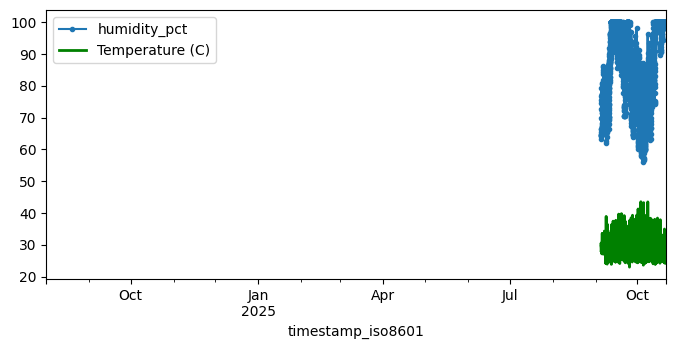

In [212]:
# Plotting
import matplotlib.pyplot as plt

# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)

# Add a legend to distinguish them
ax.legend()

In [213]:
# The gaps indicate times the board was off

In [214]:
df = df.interpolate(method="linear")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21447 entries, 2024-08-01 00:00:00+00:00 to 2025-10-21 19:00:00+00:00
Freq: 30min
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   humidity_pct              2251 non-null   float64
 1   lux_lx                    2251 non-null   float64
 2   om_precipitation_mm       21447 non-null  float64
 3   om_relative_humidity_pct  21447 non-null  float64
 4   om_surface_pressure_pa    21447 non-null  float64
 5   om_temperature_2m_c       21447 non-null  float64
 6   om_wind_speed_10m_ms      21447 non-null  float64
 7   pressure_pa               2251 non-null   float64
 8   temperature_c             2251 non-null   float64
dtypes: float64(9)
memory usage: 2.1 MB


In [215]:

import numpy as np

# Remove any remaining non-finite values before scaling to avoid NaNs in training weights
numeric_cols = df.select_dtypes(include="number").columns
before_clean = len(df)
df = df.loc[:, ~df.columns.duplicated()]
df = df[np.isfinite(df[numeric_cols]).all(axis=1)]
print(f"Dropped {before_clean - len(df)} rows with non-finite values.")
df.head()


Dropped 19196 rows with non-finite values.


,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c
timestamp_iso8601,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,0.0,80.0,101370.0,27.2,12.4,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,0.0,80.0,101370.0,27.2,12.4,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,0.0,80.0,101370.0,27.2,12.4,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,0.0,80.0,101370.0,27.2,12.4,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,0.0,80.0,101370.0,27.2,12.4,101026.242403,29.734615


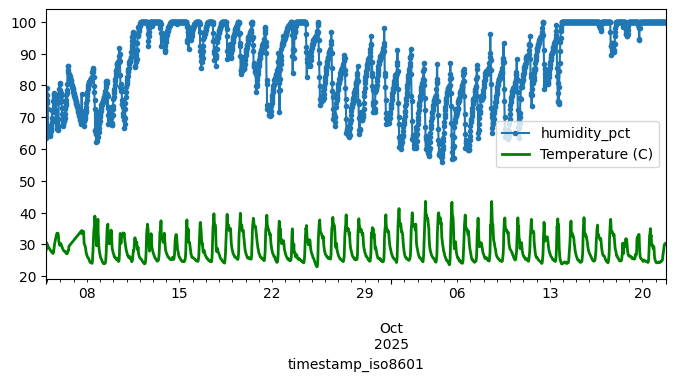

In [216]:
# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)
# Add a legend to distinguish them
ax.legend()

# Feature Engineering
We include the following features:
1. `sine_hour` - This captures the cyclical nature of the hour of the day. e.g. when taking the sine of the hour of the day, 23:00 is closer to 00:00 as it should be.
2. `cos_hour` - Similar to the above.
3. `temperature_delta` -  The difference between the temperature at the current timestamp and the timestamp immediately before.
4. `temp_mean_6h` - The average temperature over the past 6 hours at this current timestamp.
5. `temp_humidity_6h` - The average humidity over the past 6 hours at this current timestamp.

In [217]:
hour_of_day = df.index.hour
hour_of_day

Index([22, 22, 23, 23,  0,  0,  1,  1,  2,  2,
       ...
       14, 15, 15, 16, 16, 17, 17, 18, 18, 19],
      dtype='int32', name='timestamp_iso8601', length=2251)

In [218]:
import numpy as np

df["sine_hour"] = np.sin(2 * np.pi * hour_of_day / 24)
df["cos_hour"] = np.cos(2 * np.pi * hour_of_day / 24)
df.head()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c,sine_hour,cos_hour
timestamp_iso8601,,,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,0.0,80.0,101370.0,27.2,12.4,100973.617845,28.172483,-0.500000,0.866025
2025-09-04 22:30:00+00:00,69.947520,42.181484,0.0,80.0,101370.0,27.2,12.4,100969.579486,28.347315,-0.500000,0.866025
2025-09-04 23:00:00+00:00,75.398518,97.414887,0.0,80.0,101370.0,27.2,12.4,100973.551907,30.579943,-0.258819,0.965926
2025-09-04 23:30:00+00:00,76.887413,97.793978,0.0,80.0,101370.0,27.2,12.4,101008.485453,30.319356,-0.258819,0.965926
2025-09-05 00:00:00+00:00,79.289795,97.822113,0.0,80.0,101370.0,27.2,12.4,101026.242403,29.734615,0.000000,1.000000


In [219]:
df["delta_temperature"] = df["temperature_c"] - df["temperature_c"].shift(1)
df.head()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature
timestamp_iso8601,,,,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,0.0,80.0,101370.0,27.2,12.4,100973.617845,28.172483,-0.500000,0.866025,NaN
2025-09-04 22:30:00+00:00,69.947520,42.181484,0.0,80.0,101370.0,27.2,12.4,100969.579486,28.347315,-0.500000,0.866025,0.174832
2025-09-04 23:00:00+00:00,75.398518,97.414887,0.0,80.0,101370.0,27.2,12.4,100973.551907,30.579943,-0.258819,0.965926,2.232628
2025-09-04 23:30:00+00:00,76.887413,97.793978,0.0,80.0,101370.0,27.2,12.4,101008.485453,30.319356,-0.258819,0.965926,-0.260587
2025-09-05 00:00:00+00:00,79.289795,97.822113,0.0,80.0,101370.0,27.2,12.4,101026.242403,29.734615,0.000000,1.000000,-0.584741


In [220]:
# Since the first row will be null, we fill it with the mean for this column
df['delta_temperature'].fillna(df['delta_temperature'].mean(), inplace=True)
df.head()

/tmp/ipython-input-1216042316.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['delta_temperature'].fillna(df['delta_temperature'].mean(), inplace=True)


,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature
timestamp_iso8601,,,,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,0.0,80.0,101370.0,27.2,12.4,100973.617845,28.172483,-0.500000,0.866025,0.000968
2025-09-04 22:30:00+00:00,69.947520,42.181484,0.0,80.0,101370.0,27.2,12.4,100969.579486,28.347315,-0.500000,0.866025,0.174832
2025-09-04 23:00:00+00:00,75.398518,97.414887,0.0,80.0,101370.0,27.2,12.4,100973.551907,30.579943,-0.258819,0.965926,2.232628
2025-09-04 23:30:00+00:00,76.887413,97.793978,0.0,80.0,101370.0,27.2,12.4,101008.485453,30.319356,-0.258819,0.965926,-0.260587
2025-09-05 00:00:00+00:00,79.289795,97.822113,0.0,80.0,101370.0,27.2,12.4,101026.242403,29.734615,0.000000,1.000000,-0.584741


In [221]:
df["temp_mean_6h"] = df["temperature_c"].rolling(window=12, min_periods=1).mean()
df.head()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h
timestamp_iso8601,,,,,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,0.0,80.0,101370.0,27.2,12.4,100973.617845,28.172483,-0.500000,0.866025,0.000968,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,0.0,80.0,101370.0,27.2,12.4,100969.579486,28.347315,-0.500000,0.866025,0.174832,28.259899
2025-09-04 23:00:00+00:00,75.398518,97.414887,0.0,80.0,101370.0,27.2,12.4,100973.551907,30.579943,-0.258819,0.965926,2.232628,29.033247
2025-09-04 23:30:00+00:00,76.887413,97.793978,0.0,80.0,101370.0,27.2,12.4,101008.485453,30.319356,-0.258819,0.965926,-0.260587,29.354774
2025-09-05 00:00:00+00:00,79.289795,97.822113,0.0,80.0,101370.0,27.2,12.4,101026.242403,29.734615,0.000000,1.000000,-0.584741,29.430743


In [222]:
df["humidity_mean_6h"] = df["humidity_pct"].rolling(window=12, min_periods=1).mean()
df.head()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
timestamp_iso8601,,,,,,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,0.0,80.0,101370.0,27.2,12.4,100973.617845,28.172483,-0.500000,0.866025,0.000968,28.172483,63.341935
2025-09-04 22:30:00+00:00,69.947520,42.181484,0.0,80.0,101370.0,27.2,12.4,100969.579486,28.347315,-0.500000,0.866025,0.174832,28.259899,66.644727
2025-09-04 23:00:00+00:00,75.398518,97.414887,0.0,80.0,101370.0,27.2,12.4,100973.551907,30.579943,-0.258819,0.965926,2.232628,29.033247,69.562658
2025-09-04 23:30:00+00:00,76.887413,97.793978,0.0,80.0,101370.0,27.2,12.4,101008.485453,30.319356,-0.258819,0.965926,-0.260587,29.354774,71.393847
2025-09-05 00:00:00+00:00,79.289795,97.822113,0.0,80.0,101370.0,27.2,12.4,101026.242403,29.734615,0.000000,1.000000,-0.584741,29.430743,72.973036


## Normalizing

In [223]:
df.describe()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
count,2251.000000,2251.000000,2251.0,2251.0,2251.0,2.251000e+03,2.251000e+03,2251.000000,2251.000000,2.251000e+03,2.251000e+03,2251.000000,2251.000000,2251.000000
mean,86.075111,4456.782739,0.0,80.0,101370.0,2.720000e+01,1.240000e+01,101062.984829,28.882355,1.826828e-03,-1.187487e-03,0.000968,28.879972,86.000806
std,12.293825,6760.656839,0.0,0.0,0.0,1.076711e-12,4.495181e-13,167.271825,4.098369,7.069683e-01,7.075560e-01,1.003573,3.442058,11.864258
min,55.900582,0.000000,0.0,80.0,101370.0,2.720000e+01,1.240000e+01,100635.793644,22.989888,-1.000000e+00,-1.000000e+00,-4.365562,23.692777,58.277823
25%,75.994236,0.000000,0.0,80.0,101370.0,2.720000e+01,1.240000e+01,100940.903754,25.460715,-7.071068e-01,-7.071068e-01,-0.319517,25.784417,76.001434
50%,87.413169,94.088907,0.0,80.0,101370.0,2.720000e+01,1.240000e+01,101061.558714,27.478218,1.224647e-16,-1.836970e-16,-0.108394,28.169648,86.737498
75%,99.440533,7028.690959,0.0,80.0,101370.0,2.720000e+01,1.240000e+01,101180.300570,32.099490,7.071068e-01,7.071068e-01,0.128898,31.584787,98.495679
max,100.000000,28891.834070,0.0,80.0,101370.0,2.720000e+01,1.240000e+01,101492.141722,43.539995,1.000000e+00,1.000000e+00,4.937021,39.408742,100.000000


In [224]:
from sklearn.preprocessing import StandardScaler

# Keep an unscaled copy of the temperature targets so outputs stay in Celsius
# while inputs (including the observed temperature) are standardized
target_col = 'target_temperature_c'
df[target_col] = df['temperature_c']

feature_cols = [col for col in df.select_dtypes(include='number').columns if col != target_col]
feature_indices = [df.columns.get_loc(col) for col in feature_cols]
target_index = df.columns.get_loc(target_col)

scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])



**Note:** Unlike `microclimate_forecast_model.ipynb`, this notebook currently keeps the `temperature_c` column out of the `StandardScaler` so the network trains and predicts in real-world temperature units. In the microclimate notebook the line `combined_dataframe.drop(columns=target_column_names)` only removes the *future target* columns, so the current-temperature input *is* standardized along with the other features. If you want identical normalization here, create a separate unscaled copy of the target (e.g., `target_temperature_c`) and include `temperature_c` in the scaler's `feature_cols`.


In [225]:
df.describe()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h,target_temperature_c
count,2.251000e+03,2.251000e+03,2251.0,2251.0,2251.0,2.251000e+03,2.251000e+03,2.251000e+03,2.251000e+03,2.251000e+03,2.251000e+03,2.251000e+03,2.251000e+03,2.251000e+03,2251.000000
mean,3.409090e-16,-1.010101e-16,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-8.106058e-15,-7.891412e-17,1.736111e-17,1.736111e-17,9.864265e-18,-6.439392e-16,2.020201e-16,28.882355
std,1.000222e+00,1.000222e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00,4.098369
min,-2.454991e+00,-6.593698e-01,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-2.554442e+00,-1.438078e+00,-1.417389e+00,-1.411951e+00,-4.351953e+00,-1.507339e+00,-2.337200e+00,22.989888
25%,-8.201772e-01,-6.593698e-01,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-7.299986e-01,-8.350638e-01,-1.003003e+00,-9.979085e-01,-3.194157e-01,-8.995324e-01,-8.430020e-01,25.460715
50%,1.088640e-01,-6.454496e-01,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-8.527633e-03,-3.426847e-01,-2.584605e-03,1.678667e-03,-1.089975e-01,-2.064119e-01,6.210721e-02,27.478218
75%,1.087407e+00,3.805074e-01,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,7.015037e-01,7.851537e-01,9.978335e-01,1.001266e+00,1.275027e-01,7.859879e-01,1.053387e+00,32.099490
max,1.132925e+00,3.615104e+00,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,2.566196e+00,3.577251e+00,1.412220e+00,1.415308e+00,4.919574e+00,3.059539e+00,1.180209e+00,43.539995


# Creating the Datasets used by the Model

## Define Input Window Size and Prediction Window Size
We want to use the previous 24 hours of data to predict the next 12 hours of temperatures.

In [226]:
sample_size_in_hrs = 0.5 # we resampled to 30-min chunks
window_size_in_hrs = 24

# since each instance is a 30-min period, and we want a 24hr window
seq_length = int(window_size_in_hrs / sample_size_in_hrs)

## Train, Test Split
We use 80% of the data to train. Then the remaining 20% is then split into equal 10% segments. **No shuffling is done as the time series data needs to stay in chronological order**.

In [227]:
from sklearn.model_selection import train_test_split

# First split: 80% and 20%
df_train, df_temp = train_test_split(df, test_size=0.2,
                                     random_state=42, shuffle=False)

# Second split: split the remaining 20% into two 10% parts
df_valid, df_test = train_test_split(df_temp, test_size=0.5,
                                     random_state=42, shuffle=False)

print(f"Train: {len(df_train)}")
print(f"Valid: {len(df_valid)}")
print(f"Test: {len(df_test)}")


Train: 1800
Valid: 225
Test: 226


In [228]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1800 entries, 2025-09-04 22:00:00+00:00 to 2025-10-12 09:30:00+00:00
Freq: 30min
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   humidity_pct              1800 non-null   float64
 1   lux_lx                    1800 non-null   float64
 2   om_precipitation_mm       1800 non-null   float64
 3   om_relative_humidity_pct  1800 non-null   float64
 4   om_surface_pressure_pa    1800 non-null   float64
 5   om_temperature_2m_c       1800 non-null   float64
 6   om_wind_speed_10m_ms      1800 non-null   float64
 7   pressure_pa               1800 non-null   float64
 8   temperature_c             1800 non-null   float64
 9   sine_hour                 1800 non-null   float64
 10  cos_hour                  1800 non-null   float64
 11  delta_temperature         1800 non-null   float64
 12  temp_mean_6h              1800 non-null   float64
 13  hum

In [229]:
df_train.head()

,humidity_pct,lux_lx,om_precipitation_mm,om_relative_humidity_pct,om_surface_pressure_pa,om_temperature_2m_c,om_wind_speed_10m_ms,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h,target_temperature_c
timestamp_iso8601,,,,,,,,,,,,,,,
2025-09-04 22:00:00+00:00,-1.849565,-0.655435,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-0.534381,-0.173247,-0.709987,1.225918,0.000000,-0.205588,-1.910267,28.172483
2025-09-04 22:30:00+00:00,-1.312136,-0.653129,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-0.558529,-0.130578,-0.709987,1.225918,0.173283,-0.180186,-1.631824,28.347315
2025-09-04 23:00:00+00:00,-0.868645,-0.644958,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-0.534775,0.414303,-0.368763,1.367140,2.224210,0.044540,-1.385826,30.579943
2025-09-04 23:30:00+00:00,-0.747509,-0.644901,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-0.325886,0.350705,-0.368763,1.367140,-0.260682,0.137972,-1.231447,30.319356
2025-09-05 00:00:00+00:00,-0.552051,-0.644897,0.0,0.0,0.0,7.105427e-15,-3.552714e-15,-0.219706,0.207997,-0.002585,1.415308,-0.583754,0.160048,-1.098313,29.734615


## Converting DataFrames to Timeseries Datasets

In [230]:
import tensorflow as tf

In [231]:
import tensorflow as tf

def split_inputs_and_targets(
    multivariable_series,
    ahead: int = 24,   # next 24 half-hour slots
):
    # Split into input window and target horizon
    input_sequence = multivariable_series[:, :-ahead, :]
    # Use tf.gather to select columns using feature_indices
    inputs = tf.gather(input_sequence, tf.constant(feature_indices), axis=-1) # shape: (batch, seq_length, num_features)
    targets = multivariable_series[:, -ahead:, target_index]   # shape: (batch, ahead)

    # Tell TensorFlow the exact shapes so RNN can unroll
    # batch dimension stays None, time dimension is fixed
    inputs.set_shape((None, seq_length, len(feature_cols)))
    targets.set_shape((None, ahead))

    return inputs, targets

In [232]:
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 48, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 24), dtype=tf.float64, name=None))>

In [233]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,
    batch_size=32
).map(split_inputs_and_targets)
valid_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 48, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None, 24), dtype=tf.float64, name=None))>

# Build and Compile the Model

## I Should Use Keras Tuner here once i get the base model to run

## Definition

In [234]:
num_features = len(feature_cols)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, num_features)),
    tf.keras.layers.SimpleRNN(64, return_sequences=True,unroll=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(64,unroll=True),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(24)
])


In [235]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=15,
    restore_best_weights=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [236]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

## Training

In [237]:
history = model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500, callbacks=[early_stopping_cb]
)

Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 27.7486 - mae: 28.2486 - val_loss: 20.0450 - val_mae: 20.5450
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 15.6524 - mae: 16.1492 - val_loss: 3.7179 - val_mae: 4.1920
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 3.2406 - mae: 3.7055 - val_loss: 2.8590 - val_mae: 3.3336
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.7132 - mae: 3.1751 - val_loss: 2.4787 - val_mae: 2.9487
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6166 - mae: 3.0713 - val_loss: 2.4599 - val_mae: 2.9318
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6351 - mae: 3.0911 - val_loss: 2.4829 - val_mae: 2.9572
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6335 - mae: 3.0844 - val_loss: 2.4639 - val_mae: 2.9347
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.6675 - mae: 3.1233 - val_loss: 2.4912 - val_mae: 2.9648
Epoch 9/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/st

In [238]:
history = model.fit(
    train_ds, validation_data=valid_ds,
    epochs=500, callbacks=[early_stopping_cb]
)

Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.6219 - mae: 3.0765 - val_loss: 2.4967 - val_mae: 2.9710
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.6238 - mae: 3.0798 - val_loss: 2.5015 - val_mae: 2.9734
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6633 - mae: 3.1191 - val_loss: 2.5236 - val_mae: 2.9982
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.5930 - mae: 3.0499 - val_loss: 2.5140 - val_mae: 2.9864
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6129 - mae: 3.0660 - val_loss: 2.5063 - val_mae: 2.9821
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6193 - mae: 3.0753 - val_loss: 2.4851 - val_mae: 2.9497
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6371 - mae: 3.0904 - val_loss: 2.5357 - val_mae: 3.0117
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6646 - mae: 3.1230 - val_loss: 2.5075 - val_mae: 2.9750
Epoch 9/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - lo

In [239]:

import numpy as np

# Ensure the trained model has only finite weights before exporting to TFLite/X-CUBE-AI
for idx, weight in enumerate(model.get_weights()):
    if not np.all(np.isfinite(weight)):
        raise ValueError(f"Non-finite values found in weight tensor {idx}; check preprocessing and training stability before export.")
print("Model weights verified as finite.")


Model weights verified as finite.


# Using the Model to Make Predictions

In [240]:
def predict_12_hours(model, input_df, seq_length, start_idx, target_col_name,
                     window_size_in_hrs):
  X = input_df[feature_cols].to_numpy()[np.newaxis, start_idx:start_idx+seq_length]
  print(f"Shape of Input Data: {X.shape}")

  Y_pred = model.predict(X)[0]
  print(f"Model Prediction: {Y_pred}")

  actual_next_12_hrs = input_df[start_idx+seq_length:
                                start_idx+seq_length+window_size_in_hrs][target_col_name].to_numpy()
  print(f"Actual Next 12 Hours: {actual_next_12_hrs}")

  for i in range(window_size_in_hrs):
    model_pred_in_deg = Y_pred[i]
    actual_in_deg = actual_next_12_hrs[i]
    pred_error = model_pred_in_deg - actual_in_deg

    print(f"{(i+1) * 30} MINUTES INTO THE FUTURE!")
    print(f"Model Prediction: {model_pred_in_deg} degrees celcius.")
    print(f"Actual Value: {actual_in_deg} degrees celcius.")
    print(f"Prediction Error: {pred_error} degrees celcius.")
    print('*'*20)

  return Y_pred, actual_next_12_hrs


In [241]:
Y_pred_deg, actual_val_deg = predict_12_hours(
    model, df_valid, seq_length, 0, target_col,
    window_size_in_hrs
)


Shape of Input Data: (1, 48, 14)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model Prediction: [26.527344 26.481274 26.475895 26.468887 26.47168  26.43494  26.232685
 26.056557 25.908466 25.984932 26.60932  27.192722 28.170673 28.804533
 29.316725 29.892202 30.228836 30.604187 30.720257 31.05396  31.365877
 31.497509 31.165146 31.17492 ]
Actual Next 12 Hours: [24.65692772 25.01264446 25.52419686 26.54715869 28.64425348 32.92339755
 35.57774908 35.27805456 37.31125931 38.03783017 36.2268941  36.32646966
 35.55347094 31.49198354 29.0004531  27.39269205 26.33203901 25.44285491
 25.10318853 24.69323829 24.46773361 24.33027607 24.00600544 23.87526834]
30 MINUTES INTO THE FUTURE!
Model Prediction: 26.52734375 degrees celcius.
Actual Value: 24.656927717105262 degrees celcius.
Prediction Error: 1.8704160328947381 degrees celcius.
********************
60 MINUTES INTO THE FUTURE!
Model Prediction: 26.481273651123047 degrees celcius.
Actual Value: 25.01264445731707 degrees celcius.
Prediction Error: 1.46

# Evaluating the model on the test set

In [242]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2025-10-17 02:30:00+00:00 to 2025-10-21 19:00:00+00:00
Freq: 30min
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   humidity_pct              226 non-null    float64
 1   lux_lx                    226 non-null    float64
 2   om_precipitation_mm       226 non-null    float64
 3   om_relative_humidity_pct  226 non-null    float64
 4   om_surface_pressure_pa    226 non-null    float64
 5   om_temperature_2m_c       226 non-null    float64
 6   om_wind_speed_10m_ms      226 non-null    float64
 7   pressure_pa               226 non-null    float64
 8   temperature_c             226 non-null    float64
 9   sine_hour                 226 non-null    float64
 10  cos_hour                  226 non-null    float64
 11  delta_temperature         226 non-null    float64
 12  temp_mean_6h              226 non-null    float64
 13  humi

In [243]:
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_test.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,  # same as in training
    batch_size=32
).map(split_inputs_and_targets)


In [244]:
results = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5238 - mae: 1.9694


In [245]:
test_mae = results[1]
test_mae

2.1307265758514404

In [246]:
test_mae_deg = test_mae
print(f"Test MAE Degrees Celcius: {test_mae_deg}")

Test MAE Degrees Celcius: 2.1307265758514404


# Preparing the Model for Deployment on the Embedded Board

## Structured pruning and footprint analysis
We apply a manual, structured pruning pass to the RNN (removing the weakest neurons per layer) and log the footprint at each stage (full, pruned, and quantized).
Pinned NumPy wheels remain to avoid ABI conflicts seen on Colab.


In [247]:
import os
import tempfile
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2


def calculate_macs(model):
    sample_spec = tf.TensorSpec([1, seq_length, num_features], tf.float32)
    concrete_func = tf.function(model).get_concrete_function(sample_spec)
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

    macs = flops.total_float_ops // 2 if flops is not None else None
    return macs


def get_model_size_kb(model):
    fd, temp_path = tempfile.mkstemp(suffix='.h5')
    os.close(fd)
    model.save(temp_path, include_optimizer=False)
    size_kb = os.path.getsize(temp_path) / 1024
    os.remove(temp_path)
    return size_kb


def summarize_keras_model(label, model):
    macs = calculate_macs(model)
    macs_display = f"{macs:,}" if macs is not None else 'N/A'
    params = model.count_params()
    size_kb = get_model_size_kb(model)
    print(f"""{label}:
 - Parameters: {params:,}
 - MACs (approx): {macs_display}
 - Size: {size_kb:.2f} KB
""")


def summarize_tflite_model(label, tflite_bytes, reference_keras_model=None):
    params = reference_keras_model.count_params() if reference_keras_model else 'N/A'
    macs = calculate_macs(reference_keras_model) if reference_keras_model else None
    macs_display = f"{macs:,}" if macs is not None else 'N/A'

    interpreter = tf.lite.Interpreter(model_content=tflite_bytes)
    interpreter.allocate_tensors()
    tensor_details = interpreter.get_tensor_details()

    def tensor_ram_bytes(detail):
        dtype = np.dtype(detail["dtype"])
        shape = detail.get("shape_signature", detail.get("shape"))
        shape = [dim if dim > 0 else 1 for dim in shape]
        return int(np.prod(shape)) * dtype.itemsize

    sram_bytes = sum(
        tensor_ram_bytes(detail)
        for detail in tensor_details
        if detail.get("buffer", 0) == 0 or detail.get("is_variable", False)
    )
    sram_kb = sram_bytes / 1024

    print(f"""{label}:
 - Parameters: {params:,}
 - MACs (approx): {macs_display}
 - Estimated SRAM (tensor arena): {sram_kb:.2f} KB
""")


In [248]:
# Baseline footprint before pruning
summarize_keras_model("Full Keras model", model)

Full Keras model:
 - Parameters: 19,032
 - MACs (approx): 644,652
 - Size: 105.91 KB



In [249]:
# Structured pruning helper functions
import numpy as np
import tensorflow as tf

def structured_prune_model(model, target_sparsity=0.5):
    """Clone a model and zero-out the least important recurrent units.

    The function measures per-unit importance using the L2 norm of each
    output column across the input and recurrent kernels, then keeps the
    strongest units to reach the requested sparsity.
    """
    target_sparsity = float(target_sparsity)
    target_sparsity = min(max(target_sparsity, 0.0), 0.95)

    pruned_model = tf.keras.models.clone_model(model)
    pruned_model.build(model.input_shape)
    pruned_model.set_weights(model.get_weights())

    pruning_masks = {}

    for layer in pruned_model.layers:
        # Focus on layers that expose a kernel (Dense/RNN family).
        if hasattr(layer, "kernel") and layer.kernel is not None:
            kernel = layer.kernel.numpy()
            units = kernel.shape[-1]
            keep_units = max(1, int(round(units * (1 - target_sparsity))))

            # Measure importance per output unit.
            importance = np.linalg.norm(kernel.reshape(-1, units), axis=0)
            if hasattr(layer, "recurrent_kernel") and layer.recurrent_kernel is not None:
                recurrent_kernel = layer.recurrent_kernel.numpy()
                importance += np.linalg.norm(recurrent_kernel.reshape(-1, units), axis=0)
            keep_indices = np.argsort(importance)[-keep_units:]

            # Apply masks to kernel, recurrent kernel, and bias.
            kernel_mask = np.zeros_like(kernel)
            kernel_mask[..., keep_indices] = 1
            layer.kernel.assign(kernel * kernel_mask)
            pruning_masks[f"{layer.name}_kernel"] = tf.constant(kernel_mask)

            if hasattr(layer, "recurrent_kernel") and layer.recurrent_kernel is not None:
                recurrent_mask = np.zeros_like(recurrent_kernel)
                recurrent_mask[..., keep_indices] = 1
                layer.recurrent_kernel.assign(recurrent_kernel * recurrent_mask)
                pruning_masks[f"{layer.name}_recurrent_kernel"] = tf.constant(recurrent_mask)

            if hasattr(layer, "bias") and getattr(layer, "use_bias", False):
                bias = layer.bias.numpy()
                bias_mask = np.zeros_like(bias)
                bias_mask[keep_indices] = 1
                layer.bias.assign(bias * bias_mask)
                pruning_masks[f"{layer.name}_bias"] = tf.constant(bias_mask)

    return pruned_model, pruning_masks


class StructuredPruningCallback(tf.keras.callbacks.Callback):
    """Re-apply pruning masks after every update to enforce sparsity.
    """

    def __init__(self, pruning_masks):
        super().__init__()
        self.pruning_masks = pruning_masks or {}

    def on_train_batch_end(self, batch, logs=None):
        self._apply_masks()

    def on_epoch_end(self, epoch, logs=None):
        self._apply_masks()

    def _apply_masks(self):
        for layer in self.model.layers:
            if hasattr(layer, "kernel") and layer.kernel is not None:
                key = f"{layer.name}_kernel"
                if key in self.pruning_masks:
                    layer.kernel.assign(layer.kernel * self.pruning_masks[key])

            if hasattr(layer, "recurrent_kernel") and layer.recurrent_kernel is not None:
                key = f"{layer.name}_recurrent_kernel"
                if key in self.pruning_masks:
                    layer.recurrent_kernel.assign(
                        layer.recurrent_kernel * self.pruning_masks[key]
                    )

            if hasattr(layer, "bias") and getattr(layer, "use_bias", False):
                key = f"{layer.name}_bias"
                if key in self.pruning_masks:
                    layer.bias.assign(layer.bias * self.pruning_masks[key])


In [250]:
pruned_model, pruning_masks = structured_prune_model(model, target_sparsity=0.5)

# Use a fresh optimizer so it can track the cloned model's variables.
# Reusing the previously built optimizer causes KeyErrors when it sees
# variables (e.g., the SimpleRNN kernel) that were not part of the original
# optimizer state.
pruning_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
pruning_optimizer.build(pruned_model.trainable_variables)

pruned_model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=pruning_optimizer,
    metrics=['mae']
)

pruning_callbacks = [
    StructuredPruningCallback(pruning_masks),
    early_stopping_cb,
]

pruned_history = pruned_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=pruning_callbacks,
)

summarize_keras_model("Structured pruned model", pruned_model)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 17.4977 - mae: 17.9888 - val_loss: 15.0786 - val_mae: 15.5645
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 15.6068 - mae: 16.0824 - val_loss: 14.9929 - val_mae: 15.4761
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 15.5831 - mae: 16.0548 - val_loss: 14.9803 - val_mae: 15.4603
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 15.5552 - mae: 16.0290 - val_loss: 14.9943 - val_mae: 15.4782
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 15.6013 - mae: 16.0756 - val_loss: 15.3032 - val_mae: 15.7901
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 15.7561 - mae: 16.2380 - val_loss: 15.2577 - val_mae: 15.7386
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 15.7296 - mae: 16.2110 - val_loss: 15.2607 - val_mae: 15.7404
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 15.7187 - mae: 16.1997 - val_loss: 15.2641 - val_mae: 15.7488
Epoch 9/10
55/55 ━━━━━━━━━━━━━━

Structured pruned model:
 - Parameters: 19,032
 - MACs (approx): 644,652
 - Size: 105.91 KB



In [251]:
import numpy as np
import tensorflow as tf

def _active_unit_indices(mask_tensor, layer_name):
    active = np.flatnonzero(np.any(mask_tensor.numpy() != 0, axis=0))
    if active.size == 0:
        raise ValueError(f"Pruning removed every unit in {layer_name}; lower target_sparsity or skip this layer.")
    return active

def rebuild_compact_pruned_rnn(pruned_model, pruning_masks):
    # Dynamically find layer objects for SimpleRNN and Dense layers
    rnn_layers = [layer for layer in pruned_model.layers if isinstance(layer, tf.keras.layers.SimpleRNN)]
    dense_layers = [layer for layer in pruned_model.layers if isinstance(layer, tf.keras.layers.Dense)]
    dropout_layer = [layer for layer in pruned_model.layers if isinstance(layer, tf.keras.layers.Dropout)][0] # Assuming one dropout layer

    # Get the names of the relevant layers from the pruned_model
    first_rnn_layer_name = rnn_layers[0].name
    second_rnn_layer_name = rnn_layers[1].name
    first_dense_layer_name = dense_layers[0].name # The dense layer with relu activation
    output_dense_layer_name = dense_layers[1].name # The final output dense layer

    # Determine which units survived pruning.
    # Based on the `pruning_masks` variable from kernel state, only Dense layers were pruned.
    # So, for SimpleRNN layers, we will use their original (full) number of units.

    # Units for SimpleRNN layers (assuming not pruned if masks are missing)
    first_rnn_compact_units = rnn_layers[0].units # Use original unit count
    second_rnn_compact_units = rnn_layers[1].units # Use original unit count

    # Units for Dense layers (pruned using masks)
    if f'{first_dense_layer_name}_kernel' not in pruning_masks:
        raise KeyError(f"Missing pruning mask for {first_dense_layer_name}_kernel. This layer should have been pruned. Check `structured_prune_model` output.")
    dense_units_indices = _active_unit_indices(pruning_masks[f'{first_dense_layer_name}_kernel'], first_dense_layer_name)
    output_dense_units = dense_layers[1].units # The final output layer usually not pruned in this manner


    inputs = tf.keras.Input(shape=pruned_model.input_shape[1:])
    # Rebuild SimpleRNN layers with their original unit counts (as they were not pruned)
    x = tf.keras.layers.SimpleRNN(first_rnn_compact_units, return_sequences=True, unroll=True, name='compact_rnn_0')(inputs)
    x = tf.keras.layers.Dropout(dropout_layer.rate, name='compact_dropout')(x)
    x = tf.keras.layers.SimpleRNN(second_rnn_compact_units, unroll=True, name='compact_rnn_1')(x)
    # Rebuild Dense layers based on their pruning masks
    x = tf.keras.layers.Dense(len(dense_units_indices), activation='relu', name='compact_dense_0')(x)
    outputs = tf.keras.layers.Dense(output_dense_units, name='compact_dense_1')(x)
    compact_model = tf.keras.Model(inputs, outputs, name='compact_pruned_rnn')

    # Transfer weights for SimpleRNN layers (no slicing as they were not pruned)
    original_first_rnn = pruned_model.get_layer(first_rnn_layer_name)
    k_rnn0, rk_rnn0, b_rnn0 = original_first_rnn.get_weights()
    compact_model.get_layer('compact_rnn_0').set_weights([
        k_rnn0,
        rk_rnn0,
        b_rnn0,
    ])

    original_second_rnn = pruned_model.get_layer(second_rnn_layer_name)
    k_rnn1, rk_rnn1, b_rnn1 = original_second_rnn.get_weights()
    compact_model.get_layer('compact_rnn_1').set_weights([
        k_rnn1,
        rk_rnn1,
        b_rnn1,
    ])

    # Transfer weights for the first Dense layer, using pruning masks for slicing
    original_dense_0 = pruned_model.get_layer(first_dense_layer_name)
    dk0, db0 = original_dense_0.get_weights()
    compact_model.get_layer('compact_dense_0').set_weights([
        dk0[:, dense_units_indices],
        db0[dense_units_indices],
    ])

    # Transfer weights for the output Dense layer, slicing input based on previous dense layer's pruning
    original_dense_1 = pruned_model.get_layer(output_dense_layer_name)
    dk1, db1 = original_dense_1.get_weights()
    compact_model.get_layer('compact_dense_1').set_weights([
        dk1[dense_units_indices, :],
        db1,
    ])

    print("Active units after pruning -> SimpleRNN1:{}, SimpleRNN2:{}, Dense:{}".format(
        first_rnn_compact_units, second_rnn_compact_units, len(dense_units_indices)
    ))
    return compact_model

compact_pruned_model = rebuild_compact_pruned_rnn(pruned_model, pruning_masks)
summarize_keras_model("Structurally pruned and compacted model", compact_pruned_model)

Active units after pruning -> SimpleRNN1:64, SimpleRNN2:64, Dense:32


Structurally pruned and compacted model:
 - Parameters: 16,184
 - MACs (approx): 641,820
 - Size: 91.39 KB



## Quantizing, Pruning and Saving the TFLite Model

In [252]:
def representative_dataset():
    for batch in tf.keras.utils.timeseries_dataset_from_array(
        data=df_train[feature_cols].to_numpy().astype(np.float32),
        targets=None,
        sequence_length=seq_length,
        batch_size=1,
    ).take(200):
        yield [batch]

# Convert the compact pruned model so weight pruning directly reduces file size
converter = tf.lite.TFLiteConverter.from_keras_model(compact_pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8
]
# Disable lowering of tensor list ops to avoid TF Lite conversion failures for RNN layers.
# converter._experimental_lower_tensor_list_ops = False

# Keep strict int8 inputs/outputs for fully quantized inference.
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quantized_model = converter.convert()
with open("quantized_rnn_model.tflite", "wb") as f:
    f.write(quantized_model)

summarize_tflite_model("Quantized int8 model", quantized_model, reference_keras_model=compact_pruned_model)


Saved artifact at '/tmp/tmpstj_aspb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 14), dtype=tf.float32, name='keras_tensor_66')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  134614564339536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200202320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200206160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200202128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200204816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200206736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200207696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200205584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200204048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134613200202512: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized int8 model:
 - Parameters: 16,184
 - MACs (approx): 641,820
 - Estimated SRAM (tensor arena): 78.06 KB



/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## Reload the TFLite Model

In [253]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="quantized_rnn_model.tflite")
interpreter.allocate_tensors()

# Get input and output details (optional)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model loaded successfully!")
print("Input details:", input_details)
print("Output details:", output_details)

Model loaded successfully!
Input details: [{'name': 'serving_default_keras_tensor_66:0', 'index': 0, 'shape': array([ 1, 48, 14], dtype=int32), 'shape_signature': array([-1, 48, 14], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.030718522146344185, 14), 'quantization_parameters': {'scales': array([0.03071852], dtype=float32), 'zero_points': array([14], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 651, 'shape': array([ 1, 24], dtype=int32), 'shape_signature': array([-1, 24], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.12761621177196503, -128), 'quantization_parameters': {'scales': array([0.12761621], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [254]:

# Evaluating the size of the tflite model
import os

file_path = "quantized_rnn_model.tflite"
size_in_bytes = os.path.getsize(file_path)
size_in_kb = size_in_bytes / 1024
size_in_mb = size_in_kb / 1024

print(f"Model size: {size_in_bytes} bytes ({size_in_kb:.2f} KB / {size_in_mb:.2f} MB)")


Model size: 436096 bytes (425.88 KB / 0.42 MB)


## Using the TFLite Model to Make a Prediction

In [255]:
import numpy as np

# Prepare input (same as Keras)
input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

def quantize_input(window: np.ndarray) -> np.ndarray:
    return np.clip(np.round(window / input_scale + input_zero_point), -128, 127).astype(np.int8)

def dequantize_output(tensor: np.ndarray) -> np.ndarray:
    return (tensor.astype(np.float32) - output_zero_point) * output_scale

X = df_valid[feature_cols].to_numpy()[np.newaxis, :seq_length].astype(np.float32)  # shape: (1, seq_length, features)
X_int8 = quantize_input(X) # Quantize input

# Set input tensor
interpreter.set_tensor(input_details[0]["index"], X_int8) # Pass quantized int8 input

# Run inference
interpreter.invoke()

# Get prediction
output_data_int8 = interpreter.get_tensor(output_details[0]["index"])
output_data = dequantize_output(output_data_int8) # Dequantize output
print("Prediction:", output_data)


Prediction: [[25.906092  0.       25.778475 25.778475 25.778475  0.       25.906092
   0.        0.        0.       27.054636  0.        0.        0.
   0.       29.862194 30.245043 30.500275  0.       31.01074   0.
   0.       31.01074  30.883123]]


## Evaluating the TFLite Model on the Test Dataset

In [256]:
import numpy as np

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get quantization parameters from the loaded model details
input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

def quantize_input(window: np.ndarray) -> np.ndarray:
    return np.clip(np.round(window / input_scale + input_zero_point), -128, 127).astype(np.int8)

def dequantize_output(tensor: np.ndarray) -> np.ndarray:
    return (tensor.astype(np.float32) - output_zero_point) * output_scale

seq_length = 48  # or whatever your window size is
num_features = len(feature_cols)

# Store predictions and true values
preds = []
trues = []

for start in range(len(df_test) - seq_length - 24 + 1):  # 24 is your prediction horizon
    X = df_test[feature_cols].to_numpy()[start:start+seq_length].astype(np.float32)
    X_int8 = quantize_input(X[np.newaxis, ...])  # Quantize input

    interpreter.set_tensor(input_details[0]['index'], X_int8) # Pass quantized int8 input
    interpreter.invoke()

    output_data_int8 = interpreter.get_tensor(output_details[0]['index'])
    y_pred = dequantize_output(output_data_int8)[0] # Dequantize output
    preds.append(y_pred)

    # True values for the next 24 steps of the target column (e.g., temperature)
    y_true = df_test.iloc[start+seq_length:start+seq_length+24][target_col].to_numpy()
    trues.append(y_true)


In [257]:
preds = np.array(preds)
trues = np.array(trues)

# Temperature targets are kept in their original scale, so predictions are already in Celsius
mae = np.mean(np.abs(preds - trues))


In [258]:
print(f"TFLite Model Test MAE: {mae}")
print(f"TFLite Model Test MAE Degrees Celcius: {mae}")

TFLite Model Test MAE: 14.542148938339238
TFLite Model Test MAE Degrees Celcius: 14.542148938339238
